<a href="https://colab.research.google.com/github/aa25desh/graph/blob/master/hwb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### 1
import numpy as np # A module for handling numerical arrays 
import os # A module for interacting with your operating system (e.g., listing directories)
import gzip # A module to handle gzipped files
import scipy # A module with scientific functions (such as statistical tests)
import pandas # A module that handles general data arrays, in a way that is similar to R
import matplotlib as mpl # A module for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # A module to plot prettier plots
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py # A module for interacting with hdf5 data format.
import allel; print('scikit-allel', allel.__version__) # A module to handle genetic data

# Check version of scikit-allel -- this notebook may not work with older versions
from distutils.version import LooseVersion # I import this module just to check that we have the
                                           # correct version of allel -- otherwise things
                                           # will fail
assert LooseVersion(allel.__version__) >=  LooseVersion('1.2.0'), \
                "This notebook may not work with this version of scikit-allel, requires 1.2.0"


scikit-allel 1.2.1


This is an ipython notebook. Lectures about Python, useful both for beginners and experts, can be found at http://scipy-lectures.github.io.

I recommend installing the [Anaconda](https://store.continuum.io/cshop/academicanaconda) distribution. Make sure not to pay for it! Click Anaconda Academic License; it should be free for those with academic e-mail addresses. 


Open the notebook by (1) copying this file into a directory, (2) in that directory typing
ipython notebook
and (3) selecting the notebook.

This notebook uses the scikit-allel package. Follow instructions [here](https://anaconda.org/conda-forge/scikit-allel) to install it. 

Note: if you have an older version of anaconda installed, you should start by updating anaconda. 


# The Hardy-Weinberg principle
In this exercise, we will warm up by manipulating some data from the 1000 Genomes Project and explore one of the most widely-used population genetics concepts, the Hardy-Weinberg principle. 

## Motivation
If we want to be doing population genetics, we'll have to come up with a definition of what a "population" is. We already have an idea of what a diploid species is: it's a set of individuals that can reproduce together. Within a species, we may find multiple groups whose individuals *tend* to reproduce together, because biology, geography, or cultural factors favor matings within the group. This tendency can increase the genetic similarity of individuals within the groups. 
We'll say that a *population* is a group whose individuals reproduce preferentially with each other because of an inheritable feature. The inheritable feature is typically not genetic: it can involve geographic factors (eg, Peoples of the Americas), as well as political (e.g., Canadians), cultural (e.g., French Canadians), or a mix of all these factors (e.g., Montreal Canadians fans). None of these groups are in reproductive isolation, but individuals are statistically more likely to reproduce with members of their group, and so they form populations in the sense of population genetics. But it should be clear that not all these groups are useful to study from a genetics perspective. 

This brings up the question of why we need to define populations in the first place. In short, we define populations to help us build models of genetic diversity and evolution, when we think that each population can be described more simply than the whole species. For example, we often assume that indiviudals within a population behave in a relatively uniform manner. A perfectly uniform population never truly exists, and all our models are vast simplifications, but in many cases these simple models are sufficient to understand the biology that we care about. 

A particularly simple population is one where partners choose each other entirely randomly among all individuals. When that happens, the mathematical modelling gets much easier, because we don't have to model all the individual idiosyncracies. This is extremely convenient, and the random mating assumption plays a a central role in population genetics. The first thing we might want to do when looking at genetic data, therefore, is to check whether we can get away with this random mating assumption.

Conveniently, the random mating assumption makes a very clear prediction about the genetic diversity in a population: the chromosomes inherited from each parent should be no more similar, nor dissimilar, than any two chromosomes sampled at random in the population. Therefore, if neutral alleles $a$ and $A$ segregate in a parental population, with frequencies $p_a+p_A=1$, the probability of genotypes in the descendants is 

$p_{AA}=p_A^2$, 

$p_{aA}=2 p_ap_A,$ 

$p_{aa}=p_ap_a$. 

You can verify that the expected proportion of $A$ alleles in the second generation is just  $p_A^{offspring}=p_{AA}+\frac{p_{aA}}{2}=p_A$. Therefore, both the expected frequencies of alleles and of genotypes are conserved over time--this is the Hardy-Weinberg principle. 

Even without looking at the parental population, we can sometimes see that the genotype distribution does not follow the Hardy-Weinberg principle. If the counts of alleles in a population are:


$\#_{AA}=100$

$\#_{aA}=0$

$\#_{aa}=100,$

we know that it's unlikely to have occurred in a randomly mating population--we can't find a $p_a$ and $p_A$ that match the data. If the data is consistent with the HW principle, we say that the allele is at Hardy-Weinberg equilibrium. We'll explore a few situations where Hardy-Weinberg equilibrium is not respected, but let's first look at some data and see what we find.






You can download the data file at:
ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/

Download "ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz" to your computer and take note of where you put it. 

In [0]:
### 2
vcf_file_name = 'ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'
vcf_file_path = os.path.join(os.sep, 'Users', 'aa25desh' , 'data1000gen', vcf_file_name) # Change this path as 
                                                                    # necessary!

# I used a relative path here, because I stored the data file in a directory close to the 
# notebooks. To find the file I just need to go up one directory ('..'), then go in the 
# "data/1000G" directory to use an absolute path, I would write something like
# vcf_file = os.path.join(os.sep,'Users','simon', 'data', '1000G', vcf_file_name) 
                                                            
import gzip 
for line in gzip.open(vcf_file_path,'rt'):
    if not line.startswith("##"): # Comment lines in vcf files start with ##. This skips comment lines
        print('\t'.join(line.split()[0:10])) # The first line after the comment lines is the header line, starting w/ #
                                             # It gives information about what data is contained in each column.
                                             
    if not line.startswith("#"): # After the header, we find data lines, which do not start with #
                                 # We stop after we have read one such line  
        break;
        


#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	HG00096
22	16050075	rs587697622	A	G	100	PASS	AC=1;AF=0.000199681;AN=5008;NS=2504;DP=8012;EAS_AF=0;AMR_AF=0;AFR_AF=0;EUR_AF=0;SAS_AF=0.001;AA=.|||;VT=SNP	GT	0|0


If you are not familiar with the vcf format, read about it here: http://samtools.github.io/hts-specs/VCFv4.2.pdf. It is a very commonly used format to present sequencing data for occurence_countiple individuals.

When we read the vcf file, we are reading lines of text. To analyze the data, we would need to parse the file, that is, tell python which character on each line corresponds to a position, to a genotype, to a chomosome number, etc. We would need to do this in a computationally efficient manner, because reading the file itelf is computationally demanding. And we would need to handle all kinds of possible problems with the data, such as missing genotypes, multiallelic SNPs, etc.

As is often the case in python, someone has already solved that problem for us and made it available in the scikit-allel package. 
Hopefully you were able to install the scikit-allel package -- if you did, you just saved yourself hours of pain.






Our first step will be to convert the vcf file in hdf5 format used by scikit-allel. This format takes a bit more space on disk than the compressed vcf format, but it's a lot easier (and faster) to access specific subsets of the data. It will take a few minutes to convert the file the first time we run this, but afterwards things will be much faster.

In [0]:
### 3
h5_file_name = "chr22.h5"
h5_file_path =  os.path.join(os.sep, 'Users', 'aa25desh' , 'data1000gen', h5_file_name)

Try to read the hdf5 file. If we don't find it, we'll get an OSError. In that case, we'll create the file from the vcf. This took about 6 minutes on my computer.

If you rerun the notebook a second time, the hdf5 file should exist and this should run much faster.

In [0]:
### 4
try:
    callset = h5py.File(h5_file_path, mode='r')
except OSError:
    allel.vcf_to_hdf5(vcf_file_path, h5_file_path, fields='*', overwrite=True)
    callset = h5py.File(h5_file_path, mode='r')
    

The allel package uses a variety of data structures to encode the data to save on memory and allow for fast computation. This may cause a steep learning curve, but it will hopefully pay off in the end.  

The 'callset' variable is a dictionary that contains the different types of data. 

In [0]:
### 5
list(callset.keys())

['calldata', 'samples', 'variants']

Broadly speaking, we have genotypes stored in 'calldata', meta-information about variants in 'variants', and information about samples IDs in 'samples': 

In [0]:
### 6
callset['samples']

<HDF5 dataset "samples": shape (2504,), type "|O">

Information about samples is stored as an HDF5 dataset, with 2504 elements (that is, the number of samples).  HDF5 arrays are memory-efficient because they don't load the data in memory unless it is needed. This is why the output is only giving us general information about the dataset, but is not printing the actual data. If we want to see the data, we can ask for specific elements using the array 'slice' notation. This will produce a regular in-memory array:

In [0]:
### 7
callset['samples'][:10]

array(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00107'], dtype=object)

The hdf5 format is hierarchical: whereas the 'sample' category only contained one type of data, the 'calldata' category has more information.

In [0]:
### 8
callset['calldata']

<HDF5 group "/calldata" (1 members)>

callset['calldata'] is an hdf5 'group', rather than a dataset. This is also stored as a dictionary so we can look at its keys to see the sub-categories:

In [0]:
### 9
callset['calldata'].keys()

<KeysViewHDF5 ['GT']>

Now this is still slightly annoying: when we ask for the list of keys, the ouput is just a new data structure ('KeyView'), but doesn't show us the data itslef. Once again, this is designed to save memory. If we want to see the contents, we have to convert it to an in-memory format.

In [0]:
### 10
list(callset['calldata'].keys())

['GT']

The genotypes are stored under the key 'calldata/GT'. We could refer to the data itself as callset['calldata']['GT'], or, more simply, 

In [0]:
### 11
callset['calldata/GT']

<HDF5 dataset "GT": shape (1103547, 2504, 2), type "|i1">

So we can see that the array has dimension (1103547, 2504, 2). We have:

1 103 547 snps,

2504 individuals,

2 genotypes per snp and per individual. 


This is stored as an hdf5 dataset. Because genotype data is where most of the analysis is taking place, scikit-allel has a specific storage format for genotyping data that is  similar to a numpy array, but has additional properties convenient for genotype data. For example, it has a function to count the number of distinct alleles for a given snp (this takes about a minute).

In [0]:
### 12
genotypes = allel.GenotypeChunkedArray(callset['calldata/GT'])
allele_counts = genotypes.count_alleles()

Given the matrix of allele_counts, we also have methods to identify whether a site is biallelic. 

In [0]:
### 13
is_biallelic = allele_counts.is_biallelic_01()
is_biallelic

<ChunkedArrayWrapper shape=(1103547,) dtype=bool chunks=(1048576,)
   nbytes=1.1M cbytes=38.7K cratio=27.8
   compression=gzip compression_opts=1
   values=h5py._hl.dataset.Dataset>

We'll discard the non-biallelic sites, because they make everything so messy. When discarding sites, it's always a good idea to count how many things we are discarding. We'll do this a fair amount, so we might as well define a function that does this for us:

In [0]:
### 14
def report_filter(filter_vector):
    kept = np.sum(filter_vector)
    length = filter_vector.shape[0]
    print("kept %d out of %d. Ratio kept: %2.2f " % (kept, length, kept/length))

report_filter(is_biallelic)    

kept 1093133 out of 1103547. Ratio kept: 0.99 


Now we can extract only the snps that are biallelic. We'll want to keep track of the SNP positions, the genotypes, and the allele counts. The 'compress' function allows us to extract the part of the array for which a condition evaluated to True.

In [0]:
### 15
print("original")
print(callset['variants']['ALT'][:11])
print("\n compressed")
print(np.compress(is_biallelic,callset['variants']['ALT'], axis = 0)[:11])

original
[['G' '' '']
 ['A' '' '']
 ['T' '' '']
 ['T' '' '']
 ['A' '' '']
 ['A' '' '']
 ['A' '' '']
 ['T' '' '']
 ['T' '' '']
 ['<CN0>' '<CN2>' '<CN3>']
 ['A' '' '']]

 compressed
[['G' '' '']
 ['A' '' '']
 ['T' '' '']
 ['T' '' '']
 ['A' '' '']
 ['A' '' '']
 ['A' '' '']
 ['T' '' '']
 ['T' '' '']
 ['A' '' '']
 ['T' '' '']]


We can do the same for the other arrays we will need. This also takes a couple of seconds because we need to make copies of the arrays. 

In [0]:
### 16
genotypes_biallelic = genotypes.compress(is_biallelic)
allele_counts_biallelic_all_alleles = allele_counts.compress(is_biallelic)
pos_biallelic = callset['variants/POS'][:].compress(is_biallelic)

Let's have a look at the resulting genotype and genotype count arrays

In [0]:
### 17
genotypes_biallelic[0:10]

<GenotypeArray shape=(10, 2504, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [0]:
### 18
allele_counts_biallelic_all_alleles[0:10]

<AlleleCountsArray shape=(10, 9) dtype=int32>
5007    1    0    0    0    0    0    0    0
4976   32    0    0    0    0    0    0    0
4970   38    0    0    0    0    0    0    0
...
5006    2    0    0    0    0    0    0    0
5007    1    0    0    0    0    0    0    0
5007    1    0    0    0    0    0    0    0

This has plenty of columns because we used to have multiallelic variants. We can compress to extract columns as well:

In [0]:
### 19
relevant_column = np.array([False] * allele_counts_biallelic_all_alleles.shape[1])
relevant_column[0:2] = True
allele_counts_biallelic = allele_counts_biallelic_all_alleles.compress(relevant_column, axis = 1)

In [0]:
### 20
allele_counts_biallelic[0:10]

array([[5007,    1],
       [4976,   32],
       [4970,   38],
       [5007,    1],
       [5007,    1],
       [5006,    2],
       [5003,    5],
       [5006,    2],
       [5007,    1],
       [5007,    1]], dtype=int32)

Given the allele counts, it is easy to compute the frequency of the alternate allele:

In [0]:
### 21
alt_allele_freqs = allele_counts_biallelic[:,1] / allele_counts_biallelic[:].sum(axis = 1)

In this notebook, we don't really care about whether a genotype is listed as 1/0 or 0/1 -- we only care about whether we have 0, 1, or 2 copies of the alternate allele. We can convert genotype data into integer value alternate allele count using to_n_alt 

In [0]:
### 22

genotypes_012 = genotypes_biallelic.to_n_alt(fill=-1)

### Testing for Hardy-Weinberg
There are many distributions of genotype counts that can produce the same number of reference and alternate alleles. 
If I have 8 copies of the A allele and 8 copies of the a allele divided among 8 diploid individuals, we could have the following configuration:

AA AA aA Aa Aa Aa aa aa

which obeys the Hardy-Weinberg proportions perfectly.


$p_{A}=\frac{1}{2}$

$p_{a}=\frac{1}{2}$

$p_{aa}=\frac{1}{4} = p_a^2$

$p_{AA}=\frac{1}{4} = p_A^2$

$p_{aA}=\frac{1}{2} = 2 p_a p_A$



Let's first code functions that will compute the HW genotype proportions:




In [0]:
### 23
def proportion_hom_ref(frequencies):
    """computes the proportion of homozygote reference genotypes at a given alternate allele 
    frequency. This should work when frequency is a number or an array of frequencies.
    The output should have the same dimension as the input.
    """
    return (1-frequencies)**2 #s/n.*/n .../

def proportion_het(frequencies):
    """computes the proportion of heterozygote genotypes at a given aleternate allele frequency.
    This should work when frequency is a number or a vector of frequency.
    The output should have the same dimension as the input.
    """
    return 2*frequencies*(1-frequencies) #s/n.*/n .../



def proportion_hom_alt(frequencies):
    """computes the proportion of homozygote alternate genotypes at a given alternate allele frequency..
    This should work when frequency is a number or a vector of frequency.
    The output should have the same dimension as the input.
    """
    return frequencies**2 #s/n.*/n .../
    

These are expectations under a theoretical model. The next step is to look at the data to see if the model describes the data well. The first step is to count the genotype data 

In [0]:
### 24
homalt_counts = (genotypes_012==2).sum(axis = 1)
het_counts = (genotypes_012==1).sum(axis = 1)
homref_counts = (genotypes_012==0).sum(axis = 1)

In the next two code boxes, we'll compute the number of aa, aA, and AA at each site, and see how these proportions compare to the expectation. The resulting graph is called a "De finetti" diagram. 

Text(0.5, 1.0, 'De finetti diagram for 1000 Genomes chromosome 22')

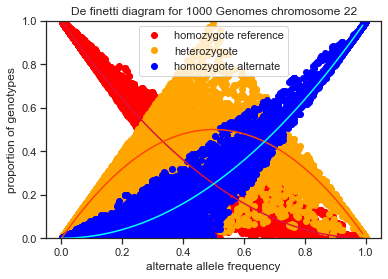

In [0]:
### 25
%matplotlib inline
import matplotlib.pyplot as plt


####
# First plot the Hardy-Weinberg expectation curves. These plots shouldn't use the data at all -- we'll just generate a
# list of frequencies, p_range, and you'll plot the expected proportion of each genotype count for each frequency.   



number_of_genotypes = homref_counts + het_counts + homalt_counts 

###########
# Then plot the observed proportion of each genotype versus the allele frequency. 
# Each snp is represented by three snps.  
plt.plot(alt_allele_freqs, np.array(homref_counts) / number_of_genotypes, 'ro', label = "homozygote reference" )
plt.plot(alt_allele_freqs, np.array(het_counts) / number_of_genotypes, 'o', color = 'orange', label = "heterozygote" )
plt.plot(alt_allele_freqs, np.array(homalt_counts) / number_of_genotypes, 'bo', label = "homozygote alternate")
plt.legend(loc='upper center')
plt.ylim([0,1])
plt.xlabel("alternate allele frequency")
plt.ylabel("proportion of genotypes")


p_range = np.arange(0,1,.01) # A sorted list of frequencies


plt.plot(p_range, proportion_hom_ref(p_range), 'crimson' ) # homozygote reference expectations 
plt.plot(p_range, proportion_het(p_range),  color = 'orangered' ) # heterozygote expectations 
plt.plot(p_range, proportion_hom_alt(p_range), 'aqua') # homozygote alternate expectations 
plt.title("De finetti diagram for 1000 Genomes chromosome 22")


            

When we don't have HW equilibrium, it suggests that the two alleles are not inherited independently--either the parents tend to be more related (if we have an excess of homozygotes), or they tend to be less related (if we have an excess of heterozygotes). The former is much more common! 

However, HW disequilibrium can mean something much less biological--it can indicate that our sequencer is biased and produces too many or too few homozygotes. This is also something that we would like to know, and detecting these issues is one of the main applications of the Hardy-Weinberg principle. 

Even if there is no such problem, we don't expect the Hardy-Weinberg proportions to hold exactly because the number of individuals is finite. When you look at the scatter of points on your figure, it's hard to tell which points truly deviate from HW, and which are complete outliers. 

To test each site for Hardy-Weinberg equilibrium, we need to build a statistical test. Our null model is that the two alleles of each individual are drawn with probability $p_a$ and $p_A=1-p_a$. Our observations are the numbers $N_{aa}$, $N_{aA}$ and $N_{AA}$ of each genotype, with $N_{aa}+N_{aA}+N_{AA}=N$. We don't quite know the probabilty $p_a$, but we can estimate it from the data:

$$\hat p_a=\frac{2N_{aa}+N_{aA}}{2N}=1-\hat p_A.$$
We then expect to have 

$N_{aa}\simeq e_{aa}=N \hat p_a^2$

$N_{AA}\simeq e_{AA}= N \hat p_{A}^2$

$N_{Aa,~aA} \simeq e_{Aa} = 2 N \hat p_{a} \hat p_{A}.$

A popular way to test the significance of departures from this distribution is to consider the test statistic

$X^2= \frac{(N_{aa}-e_{aa})^2}{e_{aa}}+ \frac{(N_{Aa}-e_{Aa})^2}{e_{Aa}}+ \frac{(N_{AA}-e_{AA})^2}{e_{AA}}.$

Intuitively, this statistic measures the departure from our null model. Perhaps less intuitively, it follows a $\chi^2_1$ (a chi-squared distribution with one degree of freedom) if the null model is true and we have enough data. 


"Enough data" means that we should expect at least a few counts in each category, so it would make sense to request at least 5 counts in both aa and AA genotypes. I.e., $e_{aa}=p_a^2*N>5$ leading to $p_a>\sqrt{5/N},$ and similarly $p_A>\sqrt{5/N}.$

**This would be a good place to complete the chisquared notebook, which explains why this statistical test is appropriate**








*Additional optional reading about Hardy-Weinberg testing* 
http://link.springer.com/protocol/10.1007%2F978-1-61779-555-8_6

To perform a chi-squared test, we first need to compute the expectations for each genotype:

In [0]:
### 26

        
        
hom_ref_expectation = allele_counts_biallelic[:,0]**2 / (4.*np.array(number_of_genotypes)) # the expected number of homozygote references #s/=.*$/= .../ 
het_expectation = allele_counts_biallelic[:,0] * allele_counts_biallelic[:,1] / (2.*np.array(number_of_genotypes))  # the expected number of hets #s/=.*$/= .../ 
hom_alt_expectation = allele_counts_biallelic[:,1]**2 / (4.*np.array(number_of_genotypes) ) # the expected number of homozygote nonreferences #s/=.*$/= .../ 



In [0]:
### 27
expectations = np.vstack([hom_ref_expectation,het_expectation, 
                                                  hom_alt_expectation] ).transpose()


observations = np.vstack([homref_counts, het_counts, 
                                                  homalt_counts] ).transpose()

In [0]:
### 28
print("expectations for snp 0")
print(expectations[0,:])
print("observations for snp 0")
print(np.array(observations[0,:]))


expectations for snp 0
[2.50300010e+03 9.99800319e-01 9.98402556e-05]
observations for snp 0
[2503    1    0]


Performing the chi-squared test is now very straightforward:

In [0]:
### 29
hw_test_results = scipy.stats.chisquare(observations, expectations, axis = 1, ddof=1)

In [0]:
### 30
hw_p_values = hw_test_results[1]
excess_het = het_counts/expectations[:,1]

In [0]:
### 31
n_inspect = 30
for i in range(n_inspect):
    print("genotypes\taa\taA\tAA")
    print("observed\t%d\t%d\t%d" % (homref_counts[i], het_counts[i], homalt_counts[i]))
    print("expected\t%2.1f\t%2.1f\t%2.1f" % (expectations[i,0], expectations[i,1], expectations[i,2]))
    print("chi-squared p-value,\t", hw_p_values[i],"\n")

genotypes	aa	aA	AA
observed	2503	1	0
expected	2503.0	1.0	0.0
chi-squared p-value,	 0.9920260702938559 

genotypes	aa	aA	AA
observed	2472	32	0
expected	2472.1	31.8	0.1
chi-squared p-value,	 0.747603804974118 

genotypes	aa	aA	AA
observed	2467	36	1
expected	2466.1	37.7	0.1
chi-squared p-value,	 0.023133620432969956 

genotypes	aa	aA	AA
observed	2503	1	0
expected	2503.0	1.0	0.0
chi-squared p-value,	 0.9920260702938559 

genotypes	aa	aA	AA
observed	2503	1	0
expected	2503.0	1.0	0.0
chi-squared p-value,	 0.9920260702938559 

genotypes	aa	aA	AA
observed	2502	2	0
expected	2502.0	2.0	0.0
chi-squared p-value,	 0.984049751812969 

genotypes	aa	aA	AA
observed	2499	5	0
expected	2499.0	5.0	0.0
chi-squared p-value,	 0.9601144369577925 

genotypes	aa	aA	AA
observed	2502	2	0
expected	2502.0	2.0	0.0
chi-squared p-value,	 0.984049751812969 

genotypes	aa	aA	AA
observed	2503	1	0
expected	2503.0	1.0	0.0
chi-squared p-value,	 0.9920260702938559 

genotypes	aa	aA	AA
observed	2503	1	0
expected	2503.0	1.0	0.0


Something here should make you feel a bit uncomfortable - we don't fulfil the conditions under which the chi-square test is accurate. So we'd want to restrict the search to places where expected counts in each category are at least 5. 

*Discussion question*

Does it mater if the number of *observations* is less than 5? Why?


So we'll now only consider snps that have enough observations to justify the chi-square test.


In [0]:
### 32
is_common = expectations.min(axis=1)>5

In [0]:
### 33
n_inspect = 100
for i in range(n_inspect):
    if is_common[i]:
        print("genotypes\taa\taA\tAA")
        print("observed\t%d\t%d\t%d" % (homref_counts[i], het_counts[i], homalt_counts[i]))
        print("expected\t%2.1f\t%2.1f\t%2.1f" % (expectations[i,0], expectations[i,1], expectations[i,2]))
        print("HW p-value,\t", hw_p_values[i],"\n")

genotypes	aa	aA	AA
observed	1995	455	54
expected	1972.6	499.7	31.6
HW p-value,	 7.572006862208043e-06 

genotypes	aa	aA	AA
observed	1797	707	0
expected	1846.9	607.2	49.9
HW p-value,	 1.9423005588494258e-16 

genotypes	aa	aA	AA
observed	746	1149	609
expected	696.4	1248.3	559.4
HW p-value,	 6.925639404283662e-05 

genotypes	aa	aA	AA
observed	2072	394	38
expected	2056.1	425.9	22.1
HW p-value,	 0.00017897567991284358 

genotypes	aa	aA	AA
observed	2144	349	11
expected	2146.7	343.5	13.7
HW p-value,	 0.4243555044945112 



A lot of these sites are significantly departing from the Hardy-Weinberg assumptions. Most of them have too many homozygotes, as we would expect under inbreeding, but a few sites have way too many hets. What do you think is going on?

If the snps obey our null model, the distribution of p-values should be uniformly distributed between 0 and 1.

*Convince yourself that this expectation should hold true, mathematically or by simulating it*

We can inspect this visually. First we'll extract the p-values for positions where the chi-square test is applicable.  



In [0]:
### 34
common_p_values  = hw_p_values.compress(is_common)
common_positions = pos_biallelic.compress(is_common) 
common_excess_het = excess_het.compress(is_common) 


Then we plot the distribution of p-values.

Text(0.5, 1.0, 'distribution of chi-squared p-values')

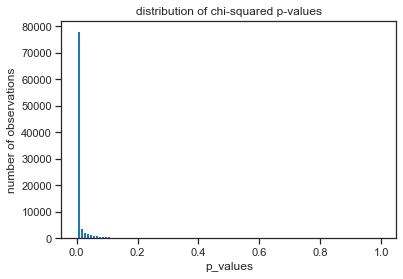

In [0]:
### 35
plt.hist(common_p_values, bins=100);
plt.xlabel("p_values")
plt.ylabel("number of observations")
plt.title("distribution of chi-squared p-values")

How do you interpret this figure? 

We'd now like to distinguish between sites who fail Hardy-Weingberg because of technical reasons from those who fail because of biological or population genetic reasons. One thing to look for is whether SNPs that fail the test clump together: sequencing artifacts tend to come in batches, and if we find a few bad regions, we'll have a hint that the errors are likely to be technical.  

Let's plot the excess of heterozygosity vs. genomic position

Text(0, 0.5, 'excess heterozygosity')

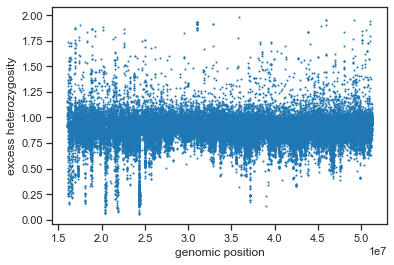

In [0]:
### 36
plt.plot(common_positions, common_excess_het[:],'o',markersize=1)
plt.xlabel("genomic position")
plt.ylabel("excess heterozygosity")

Zooming in

Text(0, 0.5, 'excess heterozygosity')

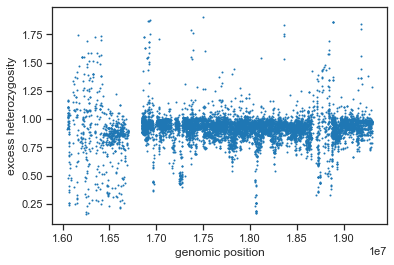

In [0]:
### 37
plt.plot(common_positions[:10000], common_excess_het[:10000],'o',markersize=1)
plt.xlabel("genomic position")
plt.ylabel("excess heterozygosity")

There appears to be regions that behave poorly. These could be regions undergoing selection, but most likely they are regions of poor call quality. Because it's a large number of sites, it's a concern. Maybe we want to report those to the 1000 Genomes project?

Before we do this, it would make sense to look at whether the problem was identified already. The 1000 genomes project has a "mask" file that tells users of the regions that should be considered trustworthy, and which should be considered with caution. 

This file is at:
ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/supporting/accessible_genome_masks/20141020.strict_mask.whole_genome.bed

from the accompanying readme file:

*The StrictMask directory uses a more stringent definition. This definition uses
a narrower band for coverage, requiring that total coverage should be within 50%
of the average, that no more than 0.1% of reads have mapping quality of zero, 
and that the average mapping quality for the position should be 56 or greater.
This definition is quite stringent and focuses on the most unique regions of the 
genome. The average total depth of coverage across Phase 3 samples is 17920. Thus, sites
with a depth of coverage of <8960 or >26880 were excluded.
Overall, this strict mask results in about 6.8% of bases marked N, 1.1% marked
L, 0.5% marked H, 16.8% marked Z, and 3.1% marked Q. The remaining 71.7% of
passed are marked passed (P) - corresponding to 76.9% of the non-N bases.*

The bed file format is often used to describe genomic regions; specifications can be found here: 

http://genome.ucsc.edu/FAQ/FAQformat.html
There's a suite of tools to handle bed files, https://github.com/arq5x/bedtools2. But here we'll want to manipulate it ourselves, so we'll write our own parser. 




In [0]:
### 38
bed_file = os.path.join(os.sep, 'Users', 'aa25desh' , 'data1000gen', '20141020.strict_mask.whole_genome.bed')

In [0]:
### 39
mask_bed = pandas.read_csv(bed_file, sep='\t', header=None)
mask_bed

,0,1,2,3
0,chr1,754450,754464,strict
1,chr1,754480,754512,strict
2,chr1,755215,755246,strict
3,chr1,756782,756872,strict
4,chr1,756880,756922,strict
...,...,...,...,...
4185731,chrY,28801544,28801571,strict
4185732,chrY,28801572,28801573,strict
4185733,chrY,28801765,28801841,strict
4185734,chrY,28801988,28802003,strict


We only care about the entries relevant to chromosome 22

In [0]:
### 40
mask_bed = mask_bed.loc[mask_bed[0] == 'chr22']
n_features = mask_bed.shape[0]
print("number of features:", n_features)
mask_bed

number of features: 55707


,0,1,2,3
3832260,chr22,16554726,16554908,strict
3832261,chr22,16848370,16848383,strict
3832262,chr22,16848391,16848394,strict
3832263,chr22,16848606,16848635,strict
3832264,chr22,16848647,16848654,strict
...,...,...,...,...
3887962,chr22,51185455,51185457,strict
3887963,chr22,51185460,51185563,strict
3887964,chr22,51185606,51185614,strict
3887965,chr22,51187902,51187951,strict


The .bed format has the particularity that the start coordinate is exclusive, and the end coordinates is exclusive, so that the first segment runs from 754451 to 754464, inclusively. This was decided so that lengths can be computed directly by taking the difference of the two columns. I disapprove of that convention.

Now, let's overlay the two pieces of information.

In [0]:
### 41
starts = np.array(mask_bed[1]) + 1
ends = np.array(mask_bed[2])

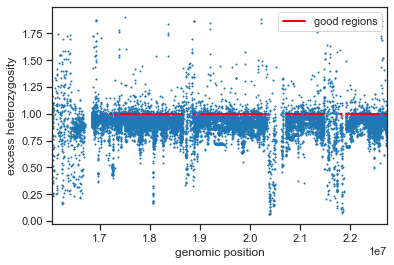

In [0]:
### 42
start_at_snp = 0
n_snps_to_plot = 20000
start_position = common_positions[0]
end_position = common_positions[n_snps_to_plot]
plt.plot(common_positions[:n_snps_to_plot], common_excess_het[:n_snps_to_plot],'o',markersize=1)
plt.xlabel("genomic position")
plt.ylabel("excess heterozygosity")
for i in range(len(starts)):
    feature_start = starts[i] 
    feature_end = ends[i]
    if (feature_start < start_position and feature_end > start_position) \
    or ( start_position < feature_start < end_position ):
        plt.plot([feature_start, feature_end], [1,1], 'r-', lw=2)
plt.plot([feature_start, feature_end], [1,1],
         'r-', lw=2, label="good regions") # Add one more to produce a legend
plt.xlim([start_position, end_position])
plt.legend(loc = "upper right")

In [0]:
### 43
in_mask = (common_positions<0) # Initialize with all False
i = 0
for _index, feature in mask_bed.iterrows():
    i+=1
    if i%10000 == 0:
        print("processed", i, "features out of", n_features)

    start = feature[1]
    end = feature[2]
      
    in_mask = np.logical_or(in_mask, np.logical_and(common_positions>=start, 
                                                    common_positions<=end))

processed 10000 features out of 55707
processed 20000 features out of 55707
processed 30000 features out of 55707
processed 40000 features out of 55707
processed 50000 features out of 55707


In [0]:
### 44
report_filter(in_mask)

kept 67799 out of 115108. Ratio kept: 0.59 


We'll refer to genotypes within the 'strict' bed file with the prefix 'strict_'.

In [0]:
### 45
strict_positions = common_positions.compress(in_mask)
strict_excess_het = common_excess_het.compress(in_mask)


We can repeat the plotting, but only with the strict variants

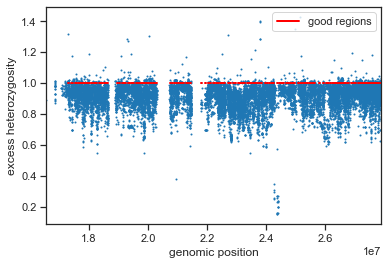

In [0]:
### 46
start_at_snp = 0
n_snps_to_plot = 20000
start_position = strict_positions[0]
end_position = strict_positions[n_snps_to_plot]
plt.plot(strict_positions[:n_snps_to_plot], strict_excess_het[:n_snps_to_plot],'o',markersize=1)
plt.xlabel("genomic position")
plt.ylabel("excess heterozygosity")
for i in range(len(starts)):
    feature_start = starts[i] 
    feature_end = ends[i]
    if (feature_start < start_position and feature_end > start_position) \
    or ( start_position < feature_start < end_position ):
        plt.plot([feature_start, feature_end], [1,1], 'r-', lw=2)
plt.plot([feature_start, feature_end], [1,1],
         'r-', lw=2, label="good regions") # Add one more to produce a legend
plt.xlim([start_position, end_position])
plt.legend(loc = "upper right")

To plot the De Finetti diagram again, but only on the strict snps, we need to extract some more information: 

In [0]:
### 47
strict_homref_counts = homref_counts.compress(is_common).compress(in_mask) 
strict_het_counts = het_counts.compress(is_common).compress(in_mask)
strict_homalt_counts = homalt_counts.compress(is_common).compress(in_mask)
strict_alt_allele_freqs = alt_allele_freqs.compress(is_common).compress(in_mask)

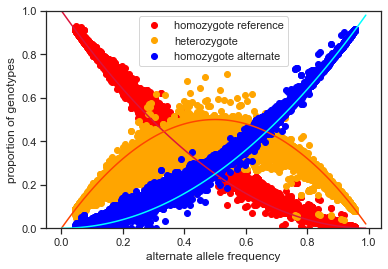

In [0]:
### 48
%matplotlib inline
import matplotlib.pyplot as plt


####
# First plot the Hardy-Weinberg expectation curves. These plots shouldn't use the data at all -- we'll just generate a
# list of frequencies, p_range, and you'll plot the expected proportion of each genotype count for each frequency.   



strict_number_of_genotypes = strict_homref_counts + strict_het_counts + strict_homalt_counts 

###########
# Then plot the observed proportion of each genotype versus the allele frequency. 
# Each snp is represented by three snps.  
plt.plot(strict_alt_allele_freqs, np.array(strict_homref_counts) / strict_number_of_genotypes, 'ro', label = "homozygote reference" )
plt.plot(strict_alt_allele_freqs, np.array(strict_het_counts) / strict_number_of_genotypes, 'o', color = 'orange', label = "heterozygote" )
plt.plot(strict_alt_allele_freqs, np.array(strict_homalt_counts) / strict_number_of_genotypes, 'bo', label = "homozygote alternate" )
plt.legend(loc='upper center')
plt.ylim([0,1])
plt.xlabel("alternate allele frequency")
plt.ylabel("proportion of genotypes")


p_range = np.arange(0,1,.01) # A sorted list of frequencies


plt.plot(p_range, proportion_hom_ref(p_range), 'crimson' ) # homozygote reference expectations 
plt.plot(p_range, proportion_het(p_range),  color = 'orangered' ) # heterozygote expectations 
plt.plot(p_range, proportion_hom_alt(p_range), 'aqua' ) # homozygote alternate expectations 



            

Things should look much better now! Do you think that alleles satisfy Hardy-Weinberg equilibrium? 

One way to check is to run again our statistical test and plot the distribution of p-values 

Text(0, 0.5, 'number of observations')

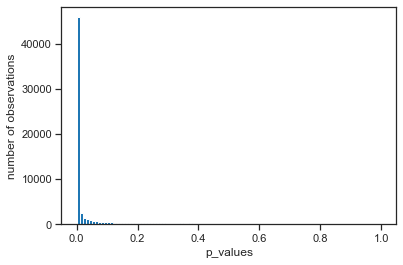

In [0]:
### 49
strict_p_values = common_p_values.compress(in_mask)
plt.hist(strict_p_values, bins=100);
plt.xlabel("p_values")
plt.ylabel("number of observations")

We still are enriched for departures from Hardy-Weinberg.  We can again plot the Hardy-Weinberg departures versus genomic positions:

We still have a bit too few heterozygotes, but now we have fewer clumps of crummy data. 

Then we are finally left to explore our population genetic hypothesis--the idea that the excess of homozygotes is caused by population structure. 

One thing that we can do to verify this further is calculate the HW statistic within each population comprising the 1000 Genomes Project. 

The information about 1000 Genomes populations is [here](goo.gl/9Hb83M)
(full path: 
ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel)


\>head integrated_call_samples_v3.20130502.ALL.panel

sample	pop	super_pop	gender		

HG00096	GBR	EUR	male

HG00097	GBR	EUR	female

HG00099	GBR	EUR	female

HG00100	GBR	EUR	female

HG00101	GBR	EUR	male

HG00102	GBR	EUR	female

HG00103	GBR	EUR	male

HG00105	GBR	EUR	male

HG00106	GBR	EUR	female

This is a small file, so we can read it in memory. The pandas library contains many useful functions to read and parse files in table format. 

In [0]:
### 50
population_file_name = 'integrated_call_samples_v3.20130502.ALL.panel'
population_file = os.path.join(os.sep, 'Users', 'aa25desh' , 'data1000gen', population_file_name)
samples = pandas.read_csv(population_file, sep='\t')
samples.head()


,sample,pop,super_pop,gender
0,HG00096,GBR,EUR,male
1,HG00097,GBR,EUR,female
2,HG00099,GBR,EUR,female
3,HG00100,GBR,EUR,female
4,HG00101,GBR,EUR,male


Count number of samples per population

In [0]:
### 51
samples['pop'].value_counts()

GWD    113
YRI    108
IBS    107
TSI    107
CHS    105
JPT    104
PUR    104
GIH    103
CHB    103
ITU    102
STU    102
ESN     99
LWK     99
FIN     99
CEU     99
KHV     99
PJL     96
ACB     96
CLM     94
CDX     93
GBR     91
BEB     86
MSL     85
PEL     85
MXL     64
ASW     61
Name: pop, dtype: int64

In [0]:
### 52
populations = np.array(samples['pop'].value_counts().keys())
populations

array(['GWD', 'YRI', 'IBS', 'TSI', 'CHS', 'JPT', 'PUR', 'GIH', 'CHB',
       'ITU', 'STU', 'ESN', 'LWK', 'FIN', 'CEU', 'KHV', 'PJL', 'ACB',
       'CLM', 'CDX', 'GBR', 'BEB', 'MSL', 'PEL', 'MXL', 'ASW'],
      dtype=object)

Find positions of samples within each population

In [0]:
### 53
# index samples using positions
samples.reset_index(drop=True, inplace=True)
samples.head()

subpops = {
    # for each population, get the list of samples that belong to the population
    pop_iter: samples[samples['pop'] == pop_iter].index.tolist() for pop_iter in populations
}

In [0]:
### 54
subpops

{'GWD': [945,
  946,
  947,
  948,
  983,
  984,
  985,
  986,
  987,
  988,
  989,
  992,
  993,
  994,
  995,
  996,
  997,
  998,
  999,
  1005,
  1006,
  1007,
  1008,
  1009,
  1010,
  1011,
  1012,
  1013,
  1014,
  1015,
  1016,
  1017,
  1018,
  1019,
  1020,
  1031,
  1032,
  1033,
  1034,
  1035,
  1036,
  1050,
  1051,
  1052,
  1053,
  1054,
  1055,
  1065,
  1066,
  1067,
  1068,
  1069,
  1070,
  1071,
  1072,
  1073,
  1086,
  1087,
  1088,
  1089,
  1090,
  1091,
  1092,
  1093,
  1094,
  1095,
  1096,
  1097,
  1098,
  1099,
  1100,
  1101,
  1102,
  1103,
  1104,
  1105,
  1106,
  1107,
  1108,
  1109,
  1110,
  1111,
  1112,
  1113,
  1114,
  1115,
  1116,
  1117,
  1118,
  1119,
  1120,
  1121,
  1122,
  1142,
  1143,
  1154,
  1155,
  1156,
  1157,
  1158,
  1159,
  1160,
  1161,
  1162,
  1163,
  1244,
  1245,
  1246,
  1247,
  1248,
  1249,
  1329,
  1330],
 'YRI': [1755,
  1756,
  1757,
  1758,
  1759,
  1760,
  1761,
  1762,
  1763,
  1764,
  1765,
  1766,
  17

We'll now extract genotypes within the stric mask so that we can compute Hardy-Weinberg properties within each population. The following step takes a few minutes

In [0]:
### 55
strict_genotypes = genotypes_biallelic.compress(is_common).compress(in_mask)
strict_genotypes_012 = genotypes_012.compress(is_common).compress(in_mask)
ac_subpops = strict_genotypes.count_alleles_subpops(subpops, max_allele=1)

The next step is a bit of a hack. I wanted to use the .count_alleles_subpops function to count the number of homozygotes and heterozygotes within each sub-population. This was not supported, so I cheat by pretending that the genotypes 0,1, and 2 are actually three different alleles in a haploid individual. 

In [0]:
### 56
genotype_012_as_triallelic_haploid = allel.GenotypeArray(strict_genotypes_012[:].reshape(
    [strict_genotypes_012.shape[0], strict_genotypes_012.shape[1], 1]))

In [0]:
### 57
observed_counts = genotype_012_as_triallelic_haploid.count_alleles_subpops(subpops, max_allele=2)

Expected heterozygosity within a population

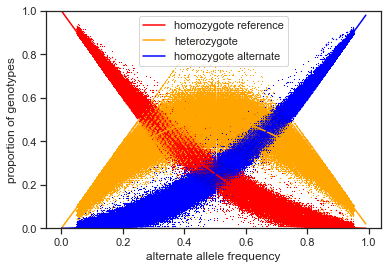

In [0]:
### 58

for i,pop in enumerate(populations):
    #to reduce the plotting burden, don't plot unless freqency is above 5%
    
    freq = ac_subpops[pop][:,1]/ac_subpops[pop].sum(axis = 1)
    iscommon = np.logical_and((freq>0.05), (freq<0.95))
    freq_common = freq.compress(iscommon)
    counts = observed_counts[pop].compress(iscommon)
    tot_counts = counts.sum(axis = 1)
    
    
    
    plt.plot(freq_common, counts[:,0]/ tot_counts, 'x', 
             color = 'r', markersize = 0.5 )
    plt.plot(freq_common[:], counts[:,1]/ tot_counts[:], 'x', 
             color = 'orange', markersize = 0.5)
    plt.plot(freq_common, counts[:,2]/ tot_counts,'x', 
             color = 'b', markersize = 0.5 )
    plt.ylim([0,1])
    plt.xlabel("alternate allele frequency")
    plt.ylabel("proportion of genotypes")
    
    ####
    # Now plot the theory values

x_range = np.arange(0,1,.01) # A list of sorted values to help in plotting

plt.plot(x_range, proportion_hom_ref(x_range), 'r', 
         label = "homozygote reference" ) 
plt.plot(x_range,  proportion_het(x_range),  color = 'orange', label = "heterozygote" ) 
plt.plot(x_range,  proportion_hom_alt(x_range), 'b',label = "homozygote alternate" ) 
plt.legend(loc = "upper center")

Compute the heterozygosity vs expectations within each population.

In [0]:
### 59
het_expectations = {}
excess_hets = {}
excess_hets_ratio = {}
het_count_cutoff = 0
for population in populations:
    allele_counts_subpop = ac_subpops[population]
    number_of_genotypes_subpop = observed_counts[population].sum(axis=1)
    het_expectation = allele_counts_subpop[:,0] * allele_counts_subpop[:,1] / (2.*np.array(
        number_of_genotypes_subpop)) 
    filter_expectations = het_expectation > het_count_cutoff

    het_expectations[population] = np.compress(filter_expectations, het_expectation)
    excess_hets[population] = np.compress(filter_expectations, observed_counts[population][:,1]-het_expectation)
    excess_hets_ratio[population] = np.compress(filter_expectations, observed_counts[population][:,1]) \
                                /np.compress(filter_expectations, het_expectation)

(-5, 5)

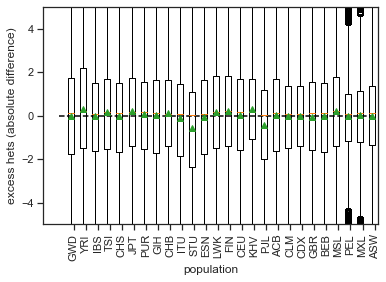

In [0]:
### 60
plt.boxplot([list(excess_hets[pop])[:] for pop in populations], showmeans = True);
plt.plot([0,len(populations)],[0,0],'k--')
plt.xticks(np.arange(len(populations))+1.2,populations, rotation=90);
plt.xlabel("population")
plt.ylabel("excess hets (absolute difference)")
plt.ylim([-5,5])

The overall counts of heterozygotes vs the number predicted by Hardy-Weinberg. We have a bit too many observed heterozygotes. I'm not sure why. 

In [0]:
### 61
print("expected", np.sum([het_expectations[pop][:].sum() for pop in populations]))
print("observed", np.sum([excess_hets[pop].sum() + het_expectations[pop][:].sum()for pop in populations]))

expected 45729602.48760315
observed 45751994.0


Text(0, 0.5, 'excess hets ratio')

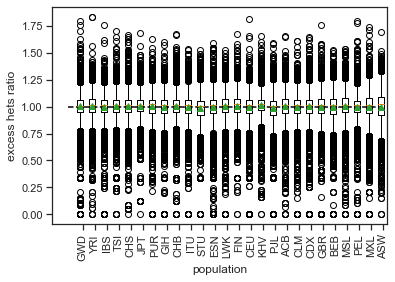

In [0]:
### 62
plt.boxplot([list(excess_hets_ratio[pop])[:] for pop in populations], showmeans = True);
plt.plot([0,len(populations)],[1,1],'k--')
plt.xticks(np.arange(len(populations))+1.2,populations, rotation=90);
plt.xlabel("population")
plt.ylabel("excess hets ratio")

Finally, we compute the excess heterozygosity per individual rather than per per SNP.

In [0]:
### 63
het_per_sample = (genotype_012_as_triallelic_haploid==1).sum(axis = 0)

For each population, compute the expected heterozygosity per individual (this is the same for all individuals in the population)

In [0]:
### 64
het_per_sample
excess_het_per_sample_per_pop = {} 
total_observed_hets = 0
total_expected_hets = 0
for pop in populations:
    expected_hets = het_expectations[pop].sum()/samples['pop'].value_counts()[pop]
    observed_hets = het_per_sample[subpops[pop]]
    excess_het_per_sample_per_pop[pop] = observed_hets - expected_hets
    total_observed_hets += np.sum(het_per_sample[subpops[pop]])
    total_expected_hets += het_expectations[pop].sum()

Text(0.5, 1.0, 'distribution of excess hets per individual')

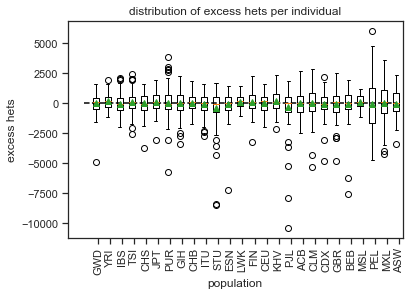

In [0]:
### 65
_=plt.boxplot([excess_het_per_sample_per_pop[pop].reshape([samples['pop'].value_counts()[pop]]) 
             for pop in populations],showmeans = True)
plt.xticks(np.arange(len(populations))+1.2,populations, rotation=90);
plt.plot([0,len(populations)],[0,0],'k--')

plt.xlabel("population")
plt.ylabel("excess hets")
plt.title("distribution of excess hets per individual")


By contrast to the full population case, there doesn't appear to be a strong excess of heterozygotes once populations have been split.

When we considered the entire population, there was clearly an excess of homozygotes, but here it's more subtle. The Q-Q plots should also look better:

Here's a few questions to think about: 

* Are the 25 populations in the 1000 Genomes project truly "populations"? I.e., are they in Hardy-weinberg equilibrium?

* The code we wrote is not very efficient--we were only able to analyze a tiny subset of one genome. How would you make it more efficient? It doesn't need to be a fancy programming trick. Try it out. 

* There are still regions that fail the HW test. What do you think is going on there? How would you go about figuring it out?

# Transitions and transversions

Elevated Hardy-Weiberg disequilibrium for some variants can be an indicator of poor quality of the sequencing data. Here we discuss another measure of variant quality: the ratio of trnasitions to transversions. This should have been discussed in class -- otherwise, you can read explanations from [this scikit tutorial](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html), which I used extensively in preparing these notes. 




We can only compute transitions/transversions for biallelic sites, so we first restrict to biallelic:

In [0]:
### 66
refs = np.array(callset['variants']['REF']).compress(is_biallelic, axis=0).astype(str)
alts = np.array(callset['variants']['ALT'])[:,0].compress(is_biallelic, axis=0).astype(str)
mutations = np.char.add(refs, alts)
mutations

array(['AG', 'GA', 'CT', ..., 'AG', 'CT', 'CT'], dtype='<U511')

In [0]:
### 67
# This function is modified from http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html
#
def locate_transitions(x):
    x = np.asarray(x)
    return np.logical_or.reduce(((x == 'AG'), (x == 'GA') , (x == 'CT') , (x == 'TC')))
is_ti = locate_transitions(mutations)
is_ti

array([ True,  True,  True, ...,  True,  True,  True])

We can now define a function that takes the vector of mutations and computes the proportion of transitions to transversions:

In [0]:
### 68
# This function is copied from http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html

def ti_tv(x):
    if len(x) == 0:
        return np.nan
    is_ti = locate_transitions(x)
    n_ti = np.count_nonzero(is_ti)
    n_tv = np.count_nonzero(~is_ti)
    if n_tv > 0:
        return n_ti / n_tv
    else:
        return np.nan

In [0]:
### 69
print("ti_tv for all mutations", ti_tv(mutations))

ti_tv for all mutations 2.1271147651659486


In [0]:
### 70
common_mutations = mutations.compress(is_common)
print("ti_tv for all mutations", ti_tv(common_mutations))

ti_tv for all mutations 1.6545823532124901


In [0]:
### 71
strict_mutations = common_mutations.compress(in_mask)
print("ti_tv for all mutations", ti_tv(strict_mutations))

ti_tv for all mutations 1.9614309426050494


In [0]:
### 72
ti_tv(strict_mutations)

1.9614309426050494

In [0]:
### 73
rare_mutations = mutations.compress(1-is_common)
print("ti_tv for rare mutations", ti_tv(rare_mutations))

ti_tv for rare mutations 2.194030776867709


As expected, restricting the analysis to the strict mask increases the ti/tv ratio. This is consistent with the much higher rate of false positives in the low-quality regions. 

By contrast, the lower rate of transitions among common mutations was a surprise to me.  

© Simon Gravel, McGill University. 